In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collection_library_utils import build_collection_library
import pickle
import torch
from data_parser import data_loader_full
import io
from matplotlib import cm
from utils import params
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

file_path = 'Predicted/results.pkl'
with open(file_path, 'rb') as pickle_file:
    pred = CPU_Unpickler(pickle_file).load()

In [3]:
data_occupancy_all, data_flow_all, data_speed_all = data_loader_full()
X_occu_all, y_occu_all = data_occupancy_all[:, :2], data_occupancy_all[:, 2]
X_occu_all, y_occu_all = torch.tensor(X_occu_all, dtype=torch.float32, requires_grad=True), torch.tensor(y_occu_all, dtype=torch.float32).unsqueeze(1)

In [4]:
occu_recon = pred['occupancy_recon']
flow_recon = pred['flow_recon']
speed_recon = pred['speed_recon']

k_t = pred['k_t']
k_x = pred['k_x']
q_x = pred['q_x']
v_x = pred['v_x']
k_xx = pred['k_xx']
q_xx = pred['q_xx']
v_xx = pred['v_xx']

coeff = pred[('coefficients')]

### 3 mins prediction

In [5]:
z = torch.cat((occu_recon, flow_recon, speed_recon, k_x, q_x, v_x, k_xx, q_xx, v_xx), dim=1)
Theta = build_collection_library(z, poly_order=params['poly_order'], include_sine=False, device= torch.device('cpu'))
k_t_predict = torch.matmul(Theta, coeff)

In [6]:
occu_1 = occu_recon + k_t_predict

In [7]:
pred_occu_recon = torch.cat((X_occu_all, occu_recon), dim=1).detach().numpy()
pred_occu_recon = pd.DataFrame(pred_occu_recon, columns = ['TimeStep','Station_Number','Occupancy'])
pred_occu_recon['TimeStep'] = pred_occu_recon['TimeStep'].astype(int)
pred_occu_recon['Station_Number'] = pred_occu_recon['Station_Number'].astype(int)
pred_occu_recon = pred_occu_recon.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')

In [8]:
pred_occu_1 = torch.cat((X_occu_all, occu_1), dim=1).detach().numpy()
pred_occu_1 = pd.DataFrame(pred_occu_1, columns = ['TimeStep','Station_Number','Occupancy'])
pred_occu_1['TimeStep'] = pred_occu_1['TimeStep'].astype(int)
pred_occu_1['Station_Number'] = pred_occu_1['Station_Number'].astype(int)
pred_occu_1 = pred_occu_1.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
pred_occu_1.columns = pred_occu_1.columns + 1

In [9]:
# prediction based on LWR Model
# The LWR model: dk/dt = -dq/dx, since we have k = 6*occu, thus d occu/dt = -(1/6)dq/dx
k_t_predict_LWR = -(1/6) * q_x
occu_1_LWR = occu_recon + k_t_predict_LWR

pred_occu_1_LWR = torch.cat((X_occu_all, occu_1_LWR), dim=1).detach().numpy()
pred_occu_1_LWR = pd.DataFrame(pred_occu_1_LWR, columns = ['TimeStep','Station_Number','Occupancy'])
pred_occu_1_LWR['TimeStep'] = pred_occu_1_LWR['TimeStep'].astype(int)
pred_occu_1_LWR['Station_Number'] = pred_occu_1_LWR['Station_Number'].astype(int)
pred_occu_1_LWR = pred_occu_1_LWR.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
pred_occu_1_LWR.columns = pred_occu_1_LWR.columns + 1

In [10]:
pred_flow_recon = torch.cat((X_occu_all, flow_recon), dim=1).detach().numpy()
pred_flow_recon = pd.DataFrame(pred_flow_recon, columns = ['TimeStep','Station_Number','Occupancy'])
pred_flow_recon['TimeStep'] = pred_flow_recon['TimeStep'].astype(int)
pred_flow_recon['Station_Number'] = pred_flow_recon['Station_Number'].astype(int)
pred_flow_recon = pred_flow_recon.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')

In [11]:
# prediction based on the CTM model
pred_occu_1_CTM = pred_occu_recon.iloc[1:,:].values + 1/12 * pred_flow_recon.iloc[:-1,:].values - 1/12 * pred_flow_recon.iloc[1:,:].values
pred_occu_1_CTM = pd.DataFrame(pred_occu_1_CTM, index=pred_occu_recon.iloc[1:,:].index, columns=pred_occu_recon.iloc[1:,:].columns)
pred_occu_1_CTM.columns = pred_occu_1_CTM.columns + 1

In [12]:
rmse_occu_1_proposed = np.sqrt(np.nanmean((pred_occu_recon.iloc[:,1:].values - pred_occu_1.iloc[:,:-1].values) ** 2))
print(rmse_occu_1_proposed)

mape_occu_1_proposed = np.nanmean(np.abs((pred_occu_recon.iloc[:,1:].values - pred_occu_1.iloc[:,:-1].values) / pred_occu_recon.iloc[:,1:].values)) * 100
print(mape_occu_1_proposed)

0.06411201
0.726392213255167


In [13]:
rmse_occu_1_LWR = np.sqrt(np.nanmean((pred_occu_recon.iloc[:,1:].values - pred_occu_1_LWR.iloc[:,:-1].values) ** 2))
print(rmse_occu_1_LWR)

mape_occu_1_LWR = np.nanmean(np.abs((pred_occu_recon.iloc[:,1:].values - pred_occu_1_LWR.iloc[:,:-1].values) / pred_occu_recon.iloc[:,1:].values)) * 100
print(mape_occu_1_LWR)

1.1416494
6.227071210741997


In [14]:
rmse_occu_1_CTM = np.sqrt(np.nanmean((pred_occu_recon.iloc[1:,1:].values - pred_occu_1_CTM.iloc[:,:-1].values) ** 2))
print(rmse_occu_1_CTM)

mape_occu_1_CTM = np.nanmean(np.abs((pred_occu_recon.iloc[1:,1:].values - pred_occu_1_CTM.iloc[:,:-1].values) / pred_occu_recon.iloc[1:,1:].values)) * 100
print(mape_occu_1_CTM)

0.27989566
2.4289466440677643


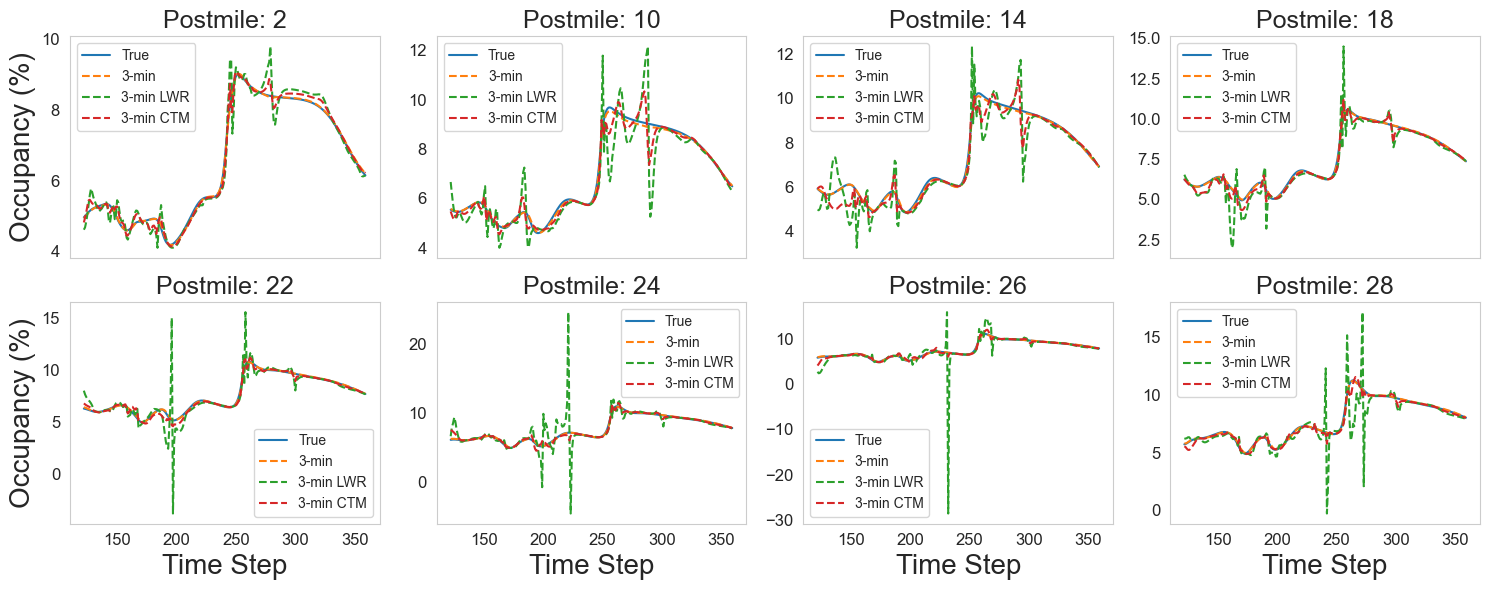

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6), sharex=True)
axes = axes.flatten()
# select the postmiles (total 8) we need to include in the plot
select_postmile = [1, 5, 7, 9, 11, 12, 13, 14]

for i in range(8):
    col = select_postmile[i]
    axes[i].plot(pred_occu_recon.loc[col, :].iloc[1:] , label='True')
    axes[i].plot(pred_occu_1.loc[col, :].iloc[:-1], linestyle = '--', label='3-min')
    axes[i].plot(pred_occu_1_LWR.loc[col, :].iloc[:-1], linestyle = '--', label='3-min LWR')
    axes[i].plot(pred_occu_1_CTM.loc[col, :].iloc[:-1], linestyle = '--', label='3-min CTM')
    
    axes[i].set_title(f'Postmile: {col * 2}', fontsize = 18)
    # axes[i].set_ylim(-0.6, 0.8)
    
    axes[i].tick_params(axis='both', which='major', labelsize=12)
    axes[i].legend()
    
    if i >= 4:  # Subplots 12 to 15 correspond to the last row (index starts from 0)
        axes[i].set_xlabel('Time Step', fontsize=20)

    # Add y-axis labels only for the subplots in the first column
    if i % 4 == 0:  # Subplots 0, 4, 8, 12 correspond to the first column
        axes[i].set_ylabel('Occupancy (%)', fontsize=20)
    axes[i].grid(False)
    
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'
fig.savefig("Figures/2-min_prediction.png", dpi=300, bbox_inches='tight')

### 6 mins preditction

In [16]:
from network import fullnetwork
from utils import params

In [17]:
# Load the checkpoint and load the checkpoint into the Network model
checkpoint = torch.load('Saved_Model/model_checkpoint.pt')
Network = fullnetwork(params).to(torch.device('cpu'))
Network.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [18]:
# convert pred_occu_1 to long format and input into Flow Net and Speed Net
pred_occu_1_long = pred_occu_1.transpose().stack().reset_index()
pred_occu_1_long.columns = ['TimeStep', 'Station_Number', 'Occupancy']

In [19]:
# change pred_occu_1_long to torch.tensor type
pred_occu_1_long = torch.tensor(pred_occu_1_long.values)

In [20]:
# input pred_occu_1 into the FlowNet and SpeedNet
flow_1 = Network.FlowNet(pred_occu_1_long.float())
speed_1 = Network.SpeedNet(pred_occu_1_long.float())

In [21]:
# change flow_1 and speed_1 into pandas long format
pred_flow_1_long = torch.cat((pred_occu_1_long.float()[:, :2], flow_1), dim=1)
pred_speed_1_long = torch.cat((pred_occu_1_long.float()[:, :2], speed_1), dim=1)
pred_flow_1_long = pd.DataFrame(pred_flow_1_long.detach().numpy())
pred_speed_1_long = pd.DataFrame(pred_speed_1_long.detach().numpy())
pred_flow_1_long.columns = ['TimeStep', 'Station_Number', 'Flow']
pred_speed_1_long.columns = ['TimeStep', 'Station_Number', 'Speed']
pred_flow_1_long['TimeStep'] = pred_flow_1_long['TimeStep'].astype(int)
pred_flow_1_long['Station_Number'] = pred_flow_1_long['Station_Number'].astype(int)
pred_speed_1_long['TimeStep'] = pred_speed_1_long['TimeStep'].astype(int)
pred_speed_1_long['Station_Number'] = pred_speed_1_long['Station_Number'].astype(int)

In [22]:
# convert these two to wide format
pred_flow_1 = pred_flow_1_long.pivot(index='Station_Number', columns='TimeStep', values='Flow')
pred_speed_1 = pred_speed_1_long.pivot(index='Station_Number', columns='TimeStep', values='Speed')

# use numpy gradiant to calculate the derivatives
# first order
pred_k_x_1 = pd.DataFrame(np.gradient(pred_occu_1.to_numpy(), axis=0), index=pred_occu_1.index, columns=pred_occu_1.columns)
pred_q_x_1 = pd.DataFrame(np.gradient(pred_flow_1.to_numpy(), axis=0), index=pred_flow_1.index, columns=pred_flow_1.columns)
pred_v_x_1 = pd.DataFrame(np.gradient(pred_speed_1.to_numpy(), axis=0), index=pred_speed_1.index, columns=pred_speed_1.columns)

# second order
pred_k_xx_1 = pd.DataFrame(np.gradient(pred_k_x_1.to_numpy(), axis=0), index=pred_k_x_1.index, columns=pred_k_x_1.columns)
pred_q_xx_1 = pd.DataFrame(np.gradient(pred_q_x_1.to_numpy(), axis=0), index=pred_q_x_1.index, columns=pred_q_x_1.columns)
pred_v_xx_1 = pd.DataFrame(np.gradient(pred_v_x_1.to_numpy(), axis=0), index=pred_v_x_1.index, columns=pred_v_x_1.columns)

In [23]:
k_x_1 = pred_k_x_1.transpose().stack().reset_index()
k_x_1 = torch.tensor(k_x_1.values)[:, 2].unsqueeze(1)

q_x_1 = pred_q_x_1.transpose().stack().reset_index()
q_x_1 = torch.tensor(q_x_1.values)[:, 2].unsqueeze(1)

v_x_1 = pred_v_x_1.transpose().stack().reset_index()
v_x_1 = torch.tensor(v_x_1.values)[:, 2].unsqueeze(1)

k_xx_1 = pred_k_xx_1.transpose().stack().reset_index()
k_xx_1 = torch.tensor(k_xx_1.values)[:, 2].unsqueeze(1)

q_xx_1 = pred_q_xx_1.transpose().stack().reset_index()
q_xx_1 = torch.tensor(q_xx_1.values)[:, 2].unsqueeze(1)

v_xx_1 = pred_v_xx_1.transpose().stack().reset_index()
v_xx_1 = torch.tensor(v_xx_1.values)[:, 2].unsqueeze(1)

In [24]:
z_1 = torch.cat((occu_1, flow_1, speed_1, k_x_1, q_x_1, v_x_1, k_xx_1, q_xx_1, v_xx_1), dim=1)
Theta_1 = build_collection_library(z_1, poly_order=params['poly_order'], include_sine=False, device= torch.device('cpu')).float()
k_t_predict_1 = torch.matmul(Theta_1, coeff)

In [25]:
occu_2 = occu_1 + k_t_predict_1 

In [26]:
pred_occu_2 = torch.cat((X_occu_all, occu_2), dim=1).detach().numpy()
pred_occu_2 = pd.DataFrame(pred_occu_2, columns = ['TimeStep','Station_Number','Occupancy'])
pred_occu_2['TimeStep'] = pred_occu_2['TimeStep'].astype(int)
pred_occu_2['Station_Number'] = pred_occu_2['Station_Number'].astype(int)
pred_occu_2 = pred_occu_2.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
pred_occu_2.columns = pred_occu_2.columns + 2

In [27]:
# prediction based on LWR Model
# The LWR model: dk/dt = -dq/dx, since we have k = 6*occu, thus d occu/dt = -(1/6)dq/dx
k_t_predict_1_LWR = -(1/6) * q_x_1
occu_2_LWR = occu_1_LWR + k_t_predict_1_LWR

pred_occu_2_LWR = torch.cat((X_occu_all, occu_2_LWR), dim=1).detach().numpy()
pred_occu_2_LWR = pd.DataFrame(pred_occu_2_LWR, columns = ['TimeStep','Station_Number','Occupancy'])
pred_occu_2_LWR['TimeStep'] = pred_occu_2_LWR['TimeStep'].astype(int)
pred_occu_2_LWR['Station_Number'] = pred_occu_2_LWR['Station_Number'].astype(int)
pred_occu_2_LWR = pred_occu_2_LWR.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
pred_occu_2_LWR.columns = pred_occu_2_LWR.columns + 2

In [28]:
# prediction based on the CTM model
pred_occu_2_CTM = pred_occu_1_CTM.values + 1/12 * pred_flow_1.iloc[:-1,:].values - 1/12 * pred_flow_1.iloc[1:,:].values
pred_occu_2_CTM = pd.DataFrame(pred_occu_2_CTM, index=pred_occu_1_CTM.index, columns=pred_occu_1_CTM.columns)
pred_occu_2_CTM.columns = pred_occu_2_CTM.columns + 1

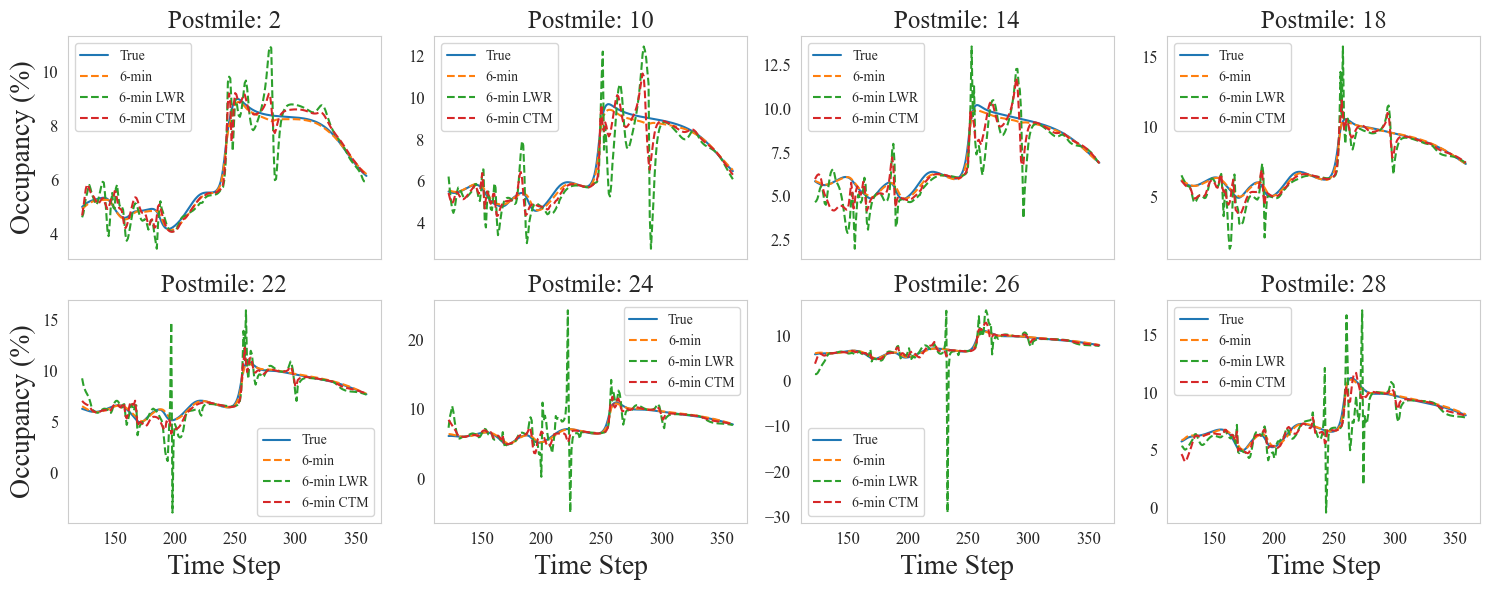

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6), sharex=True)
axes = axes.flatten()
# select the postmiles (total 8) we need to include in the plot
select_postmile = [1, 5, 7, 9, 11, 12, 13, 14]

for i in range(8):
    col = select_postmile[i]
    axes[i].plot(pred_occu_recon.loc[col,:].iloc[2:], label='True')
    axes[i].plot(pred_occu_2.loc[col,:].iloc[:-2], linestyle = '--', label='6-min')
    axes[i].plot(pred_occu_2_LWR.loc[col,:].iloc[:-2], linestyle = '--', label='6-min LWR')
    axes[i].plot(pred_occu_2_CTM.loc[col,:].iloc[:-2], linestyle = '--', label='6-min CTM')
    axes[i].set_title(f'Postmile: {col * 2}', fontsize = 18)
    # axes[i].set_ylim(-0.6, 0.8)
    
    axes[i].tick_params(axis='both', which='major', labelsize=12)
    axes[i].legend()
    
    if i >= 4:  # Subplots 12 to 15 correspond to the last row (index starts from 0)
        axes[i].set_xlabel('Time Step', fontsize=20)

    # Add y-axis labels only for the subplots in the first column
    if i % 4 == 0:  # Subplots 0, 4, 8, 12 correspond to the first column
        axes[i].set_ylabel('Occupancy (%)', fontsize=20)
    axes[i].grid(False)
    
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'

In [30]:
rmse_occu_2_proposed = np.sqrt(np.nanmean((pred_occu_recon.iloc[:,2:].values - pred_occu_2.iloc[:,:-2].values) ** 2))
print(rmse_occu_2_proposed)

mape_occu_2_proposed = np.nanmean(np.abs((pred_occu_recon.iloc[:,2:].values - pred_occu_2.iloc[:,:-2].values) / pred_occu_recon.iloc[:,2:].values)) * 100
print(mape_occu_2_proposed)

0.12680376
1.483294554054737


In [31]:
rmse_occu_2_LWR = np.sqrt(np.nanmean((pred_occu_recon.iloc[:,2:].values - pred_occu_2_LWR.iloc[:,:-2].values) ** 2))
print(rmse_occu_2_LWR)

mape_occu_2_LWR = np.nanmean(np.abs((pred_occu_recon.iloc[:,2:].values - pred_occu_2_LWR.iloc[:,:-2].values) / pred_occu_recon.iloc[:,2:].values)) * 100
print(mape_occu_2_LWR)

1.3540171648297985
9.469070557242693


In [32]:
rmse_occu_2_CTM = np.sqrt(np.nanmean((pred_occu_recon.iloc[1:,2:].values - pred_occu_2_CTM.iloc[:,:-2].values) ** 2))
print(rmse_occu_2_CTM)

mape_occu_2_CTM = np.nanmean(np.abs((pred_occu_recon.iloc[1:,2:].values - pred_occu_2_CTM.iloc[:,:-2].values) / pred_occu_recon.iloc[1:,2:].values)) * 100
print(mape_occu_2_CTM)

0.5155122
4.670968279242516


### 9 mins prediction

In [33]:
# convert pred_occu_2 to long format and input into Flow Net and Speed Net
pred_occu_2_long = pred_occu_2.transpose().stack().reset_index()
pred_occu_2_long.columns = ['TimeStep', 'Station_Number', 'Occupancy']

In [34]:
# change pred_occu_2_long to torch.tensor type
pred_occu_2_long = torch.tensor(pred_occu_2_long.values)

In [35]:
# input pred_occu_2 into the FlowNet and SpeedNet
flow_2 = Network.FlowNet(pred_occu_2_long.float())
speed_2 = Network.SpeedNet(pred_occu_2_long.float())

In [36]:
# change flow_2 and speed_2 into pandas long format
pred_flow_2_long = torch.cat((pred_occu_2_long.float()[:, :2], flow_1), dim=1)
pred_speed_2_long = torch.cat((pred_occu_2_long.float()[:, :2], speed_1), dim=1)
pred_flow_2_long = pd.DataFrame(pred_flow_2_long.detach().numpy())
pred_speed_2_long = pd.DataFrame(pred_speed_2_long.detach().numpy())
pred_flow_2_long.columns = ['TimeStep', 'Station_Number', 'Flow']
pred_speed_2_long.columns = ['TimeStep', 'Station_Number', 'Speed']
pred_flow_2_long['TimeStep'] = pred_flow_2_long['TimeStep'].astype(int)
pred_flow_2_long['Station_Number'] = pred_flow_2_long['Station_Number'].astype(int)
pred_speed_2_long['TimeStep'] = pred_speed_2_long['TimeStep'].astype(int)
pred_speed_2_long['Station_Number'] = pred_speed_2_long['Station_Number'].astype(int)

In [37]:
# convert these two to wide format
pred_flow_2 = pred_flow_2_long.pivot(index='Station_Number', columns='TimeStep', values='Flow')
pred_speed_2 = pred_speed_2_long.pivot(index='Station_Number', columns='TimeStep', values='Speed')

# use numpy gradiant to calculate the derivatives
# first order
pred_k_x_2 = pd.DataFrame(np.gradient(pred_occu_2.to_numpy(), axis=0), index=pred_occu_2.index, columns=pred_occu_2.columns)
pred_q_x_2 = pd.DataFrame(np.gradient(pred_flow_2.to_numpy(), axis=0), index=pred_flow_2.index, columns=pred_flow_2.columns)
pred_v_x_2 = pd.DataFrame(np.gradient(pred_speed_2.to_numpy(), axis=0), index=pred_speed_2.index, columns=pred_speed_2.columns)

# second order
pred_k_xx_2 = pd.DataFrame(np.gradient(pred_k_x_2.to_numpy(), axis=0), index=pred_k_x_2.index, columns=pred_k_x_2.columns)
pred_q_xx_2 = pd.DataFrame(np.gradient(pred_q_x_2.to_numpy(), axis=0), index=pred_q_x_2.index, columns=pred_q_x_2.columns)
pred_v_xx_2 = pd.DataFrame(np.gradient(pred_v_x_2.to_numpy(), axis=0), index=pred_v_x_2.index, columns=pred_v_x_2.columns)

In [38]:
k_x_2 = pred_k_x_2.transpose().stack().reset_index()
k_x_2 = torch.tensor(k_x_2.values)[:, 2].unsqueeze(1)

q_x_2 = pred_q_x_2.transpose().stack().reset_index()
q_x_2 = torch.tensor(q_x_2.values)[:, 2].unsqueeze(1)

v_x_2 = pred_v_x_2.transpose().stack().reset_index()
v_x_2 = torch.tensor(v_x_2.values)[:, 2].unsqueeze(1)

k_xx_2 = pred_k_xx_2.transpose().stack().reset_index()
k_xx_2 = torch.tensor(k_xx_2.values)[:, 2].unsqueeze(1)

q_xx_2 = pred_q_xx_2.transpose().stack().reset_index()
q_xx_2 = torch.tensor(q_xx_2.values)[:, 2].unsqueeze(1)

v_xx_2 = pred_v_xx_2.transpose().stack().reset_index()
v_xx_2 = torch.tensor(v_xx_2.values)[:, 2].unsqueeze(1)

In [39]:
z_2 = torch.cat((occu_2, flow_2, speed_2, k_x_2, q_x_2, v_x_2, k_xx_2, q_xx_2, v_xx_2), dim=1)
Theta_2 = build_collection_library(z_2, poly_order=params['poly_order'], include_sine=False, device= torch.device('cpu')).float()
k_t_predict_2 = torch.matmul(Theta_2, coeff)

In [40]:
occu_3 = occu_2 + k_t_predict_2
pred_occu_3 = torch.cat((X_occu_all, occu_3), dim=1).detach().numpy()
pred_occu_3 = pd.DataFrame(pred_occu_3, columns=['TimeStep', 'Station_Number', 'Occupancy'])
pred_occu_3['TimeStep'] = pred_occu_3['TimeStep'].astype(int)
pred_occu_3['Station_Number'] = pred_occu_3['Station_Number'].astype(int)
pred_occu_3 = pred_occu_3.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
pred_occu_3.columns = pred_occu_3.columns + 3

In [41]:
# prediction based on LWR Model
# The LWR model: dk/dt = -dq/dx, since we have k = 6*occu, thus d occu/dt = -(1/6)dq/dx
k_t_predict_2_LWR = -(1/6) * q_x_2
occu_3_LWR = occu_2_LWR + k_t_predict_2_LWR

pred_occu_3_LWR = torch.cat((X_occu_all, occu_3_LWR), dim=1).detach().numpy()
pred_occu_3_LWR = pd.DataFrame(pred_occu_3_LWR, columns = ['TimeStep','Station_Number','Occupancy'])
pred_occu_3_LWR['TimeStep'] = pred_occu_3_LWR['TimeStep'].astype(int)
pred_occu_3_LWR['Station_Number'] = pred_occu_3_LWR['Station_Number'].astype(int)
pred_occu_3_LWR = pred_occu_3_LWR.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
pred_occu_3_LWR.columns = pred_occu_3_LWR.columns + 3

In [42]:
pred_occu_3_CTM = pred_occu_2_CTM.values + 1/12 * pred_flow_2.iloc[:-1,:].values - 1/12 * pred_flow_2.iloc[1:,:].values
pred_occu_3_CTM = pd.DataFrame(pred_occu_3_CTM, index=pred_occu_2_CTM.index, columns=pred_occu_2_CTM.columns)
pred_occu_3_CTM.columns = pred_occu_3_CTM.columns + 1

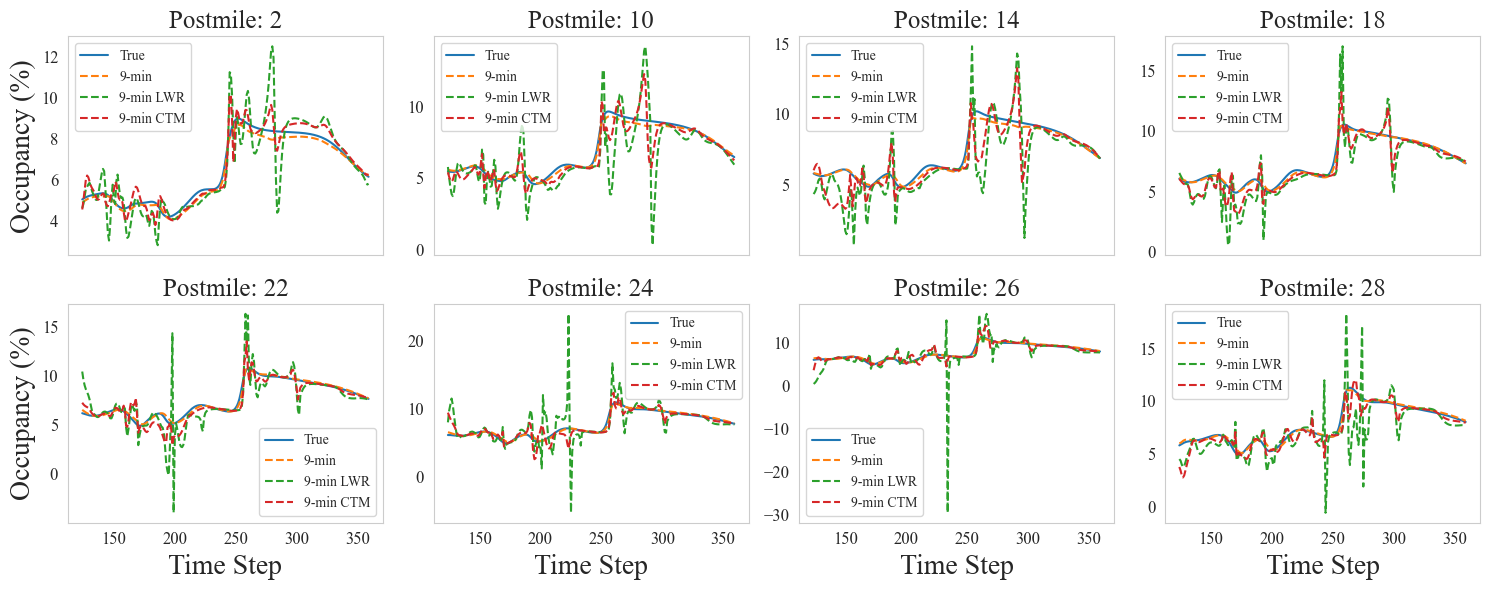

In [43]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6), sharex=True)
axes = axes.flatten()
# select the postmiles (total 8) we need to include in the plot
select_postmile = [1, 5, 7, 9, 11, 12, 13, 14]

for i in range(8):
    col = select_postmile[i]
    axes[i].plot(pred_occu_recon.loc[col,:].iloc[3:], label='True')
    axes[i].plot(pred_occu_3.loc[col,:].iloc[:-3], linestyle = '--', label='9-min')
    axes[i].plot(pred_occu_3_LWR.loc[col,:].iloc[:-3], linestyle = '--', label='9-min LWR')
    axes[i].plot(pred_occu_3_CTM.loc[col,:].iloc[:-3], linestyle = '--', label='9-min CTM')
    axes[i].set_title(f'Postmile: {col * 2}', fontsize = 18)
    # axes[i].set_ylim(-0.6, 0.8)
    
    axes[i].tick_params(axis='both', which='major', labelsize=12)
    axes[i].legend()
    
    if i >= 4:  # Subplots 12 to 15 correspond to the last row (index starts from 0)
        axes[i].set_xlabel('Time Step', fontsize=20)

    # Add y-axis labels only for the subplots in the first column
    if i % 4 == 0:  # Subplots 0, 4, 8, 12 correspond to the first column
        axes[i].set_ylabel('Occupancy (%)', fontsize=20)
    axes[i].grid(False)
    
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'

In [44]:
rmse_occu_3_proposed = np.sqrt(np.nanmean((pred_occu_recon.iloc[:,3:].values - pred_occu_3.iloc[:,:-3].values) ** 2))
print(rmse_occu_3_proposed)

mape_occu_3_proposed = np.nanmean(np.abs((pred_occu_recon.iloc[:,3:].values - pred_occu_3.iloc[:,:-3].values) / pred_occu_recon.iloc[:,3:].values)) * 100
print(mape_occu_3_proposed)

0.19486831
2.281384728848934


In [45]:
rmse_occu_3_LWR = np.sqrt(np.nanmean((pred_occu_recon.iloc[:,3:].values - pred_occu_3_LWR.iloc[:,:-3].values) ** 2))
print(rmse_occu_3_LWR)

mape_occu_3_LWR = np.nanmean(np.abs((pred_occu_recon.iloc[:,3:].values - pred_occu_3_LWR.iloc[:,:-3].values) / pred_occu_recon.iloc[:,3:].values)) * 100
print(mape_occu_3_LWR)

1.6737802550201661
13.180768400800705


In [46]:
rmse_occu_3_CTM = np.sqrt(np.nanmean((pred_occu_recon.iloc[1:,3:].values - pred_occu_3_CTM.iloc[:,:-3].values) ** 2))
print(rmse_occu_3_CTM)

mape_occu_3_CTM = np.nanmean(np.abs((pred_occu_recon.iloc[1:,3:].values - pred_occu_3_CTM.iloc[:,:-3].values) / pred_occu_recon.iloc[1:,3:].values)) * 100
print(mape_occu_3_CTM)

0.7899652
7.105279713869095


### 12 mins prediction

In [47]:
# convert pred_occu_3 to long format and input into Flow Net and Speed Net
pred_occu_3_long = pred_occu_3.transpose().stack().reset_index()
pred_occu_3_long.columns = ['TimeStep', 'Station_Number', 'Occupancy']
# change pred_occu_3_long to torch.tensor type
pred_occu_3_long = torch.tensor(pred_occu_3_long.values)
# input pred_occu_3 into the FlowNet and SpeedNet
flow_3 = Network.FlowNet(pred_occu_3_long.float())
speed_3 = Network.SpeedNet(pred_occu_3_long.float())
# change flow_3 and speed_3 into pandas long format
pred_flow_3_long = torch.cat((pred_occu_3_long.float()[:, :2], flow_1), dim=1)
pred_speed_3_long = torch.cat((pred_occu_3_long.float()[:, :2], speed_1), dim=1)
pred_flow_3_long = pd.DataFrame(pred_flow_3_long.detach().numpy())
pred_speed_3_long = pd.DataFrame(pred_speed_3_long.detach().numpy())
pred_flow_3_long.columns = ['TimeStep', 'Station_Number', 'Flow']
pred_speed_3_long.columns = ['TimeStep', 'Station_Number', 'Speed']
pred_flow_3_long['TimeStep'] = pred_flow_3_long['TimeStep'].astype(int)
pred_flow_3_long['Station_Number'] = pred_flow_3_long['Station_Number'].astype(int)
pred_speed_3_long['TimeStep'] = pred_speed_3_long['TimeStep'].astype(int)
pred_speed_3_long['Station_Number'] = pred_speed_3_long['Station_Number'].astype(int)
# convert these two to wide format
pred_flow_3 = pred_flow_3_long.pivot(index='Station_Number', columns='TimeStep', values='Flow')
pred_speed_3 = pred_speed_3_long.pivot(index='Station_Number', columns='TimeStep', values='Speed')

# use numpy gradiant to calculate the derivatives
# first order
pred_k_x_3 = pd.DataFrame(np.gradient(pred_occu_3.to_numpy(), axis=0), index=pred_occu_3.index,
                          columns=pred_occu_3.columns)
pred_q_x_3 = pd.DataFrame(np.gradient(pred_flow_3.to_numpy(), axis=0), index=pred_flow_3.index,
                          columns=pred_flow_3.columns)
pred_v_x_3 = pd.DataFrame(np.gradient(pred_speed_3.to_numpy(), axis=0), index=pred_speed_3.index,
                          columns=pred_speed_3.columns)

# second order
pred_k_xx_3 = pd.DataFrame(np.gradient(pred_k_x_3.to_numpy(), axis=0), index=pred_k_x_3.index,
                           columns=pred_k_x_3.columns)
pred_q_xx_3 = pd.DataFrame(np.gradient(pred_q_x_3.to_numpy(), axis=0), index=pred_q_x_3.index,
                           columns=pred_q_x_3.columns)
pred_v_xx_3 = pd.DataFrame(np.gradient(pred_v_x_3.to_numpy(), axis=0), index=pred_v_x_3.index,
                           columns=pred_v_x_3.columns)
k_x_3 = pred_k_x_3.transpose().stack().reset_index()
k_x_3 = torch.tensor(k_x_3.values)[:, 2].unsqueeze(1)

q_x_3 = pred_q_x_3.transpose().stack().reset_index()
q_x_3 = torch.tensor(q_x_3.values)[:, 2].unsqueeze(1)

v_x_3 = pred_v_x_3.transpose().stack().reset_index()
v_x_3 = torch.tensor(v_x_3.values)[:, 2].unsqueeze(1)

k_xx_3 = pred_k_xx_3.transpose().stack().reset_index()
k_xx_3 = torch.tensor(k_xx_3.values)[:, 2].unsqueeze(1)

q_xx_3 = pred_q_xx_3.transpose().stack().reset_index()
q_xx_3 = torch.tensor(q_xx_3.values)[:, 2].unsqueeze(1)

v_xx_3 = pred_v_xx_3.transpose().stack().reset_index()
v_xx_3 = torch.tensor(v_xx_3.values)[:, 2].unsqueeze(1)
z_3 = torch.cat((occu_3, flow_3, speed_3, k_x_3, q_x_3, v_x_3, k_xx_3, q_xx_3, v_xx_3), dim=1)
Theta_3 = build_collection_library(z_3, poly_order=params['poly_order'], include_sine=False,
                                   device=torch.device('cpu')).float()
k_t_predict_3 = torch.matmul(Theta_3, coeff)
occu_4 = occu_3 + k_t_predict_3
pred_occu_4 = torch.cat((X_occu_all, occu_4), dim=1).detach().numpy()
pred_occu_4 = pd.DataFrame(pred_occu_4, columns=['TimeStep', 'Station_Number', 'Occupancy'])
pred_occu_4['TimeStep'] = pred_occu_4['TimeStep'].astype(int)
pred_occu_4['Station_Number'] = pred_occu_4['Station_Number'].astype(int)
pred_occu_4 = pred_occu_4.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
pred_occu_4.columns = pred_occu_4.columns + 4

In [48]:
# prediction based on LWR Model
# The LWR model: dk/dt = -dq/dx, since we have k = 6*occu, thus d occu/dt = -(1/6)dq/dx
k_t_predict_3_LWR = -(1/6) * q_x_3
occu_4_LWR = occu_3_LWR + k_t_predict_3_LWR

pred_occu_4_LWR = torch.cat((X_occu_all, occu_4_LWR), dim=1).detach().numpy()
pred_occu_4_LWR = pd.DataFrame(pred_occu_4_LWR, columns = ['TimeStep','Station_Number','Occupancy'])
pred_occu_4_LWR['TimeStep'] = pred_occu_4_LWR['TimeStep'].astype(int)
pred_occu_4_LWR['Station_Number'] = pred_occu_4_LWR['Station_Number'].astype(int)
pred_occu_4_LWR = pred_occu_4_LWR.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
pred_occu_4_LWR.columns = pred_occu_4_LWR.columns + 4

In [49]:
pred_occu_4_CTM = pred_occu_3_CTM.values + 1/12 * pred_flow_3.iloc[:-1,:].values - 1/12 * pred_flow_3.iloc[1:,:].values
pred_occu_4_CTM = pd.DataFrame(pred_occu_4_CTM, index=pred_occu_3_CTM.index, columns=pred_occu_3_CTM.columns)
pred_occu_4_CTM.columns = pred_occu_4_CTM.columns + 1

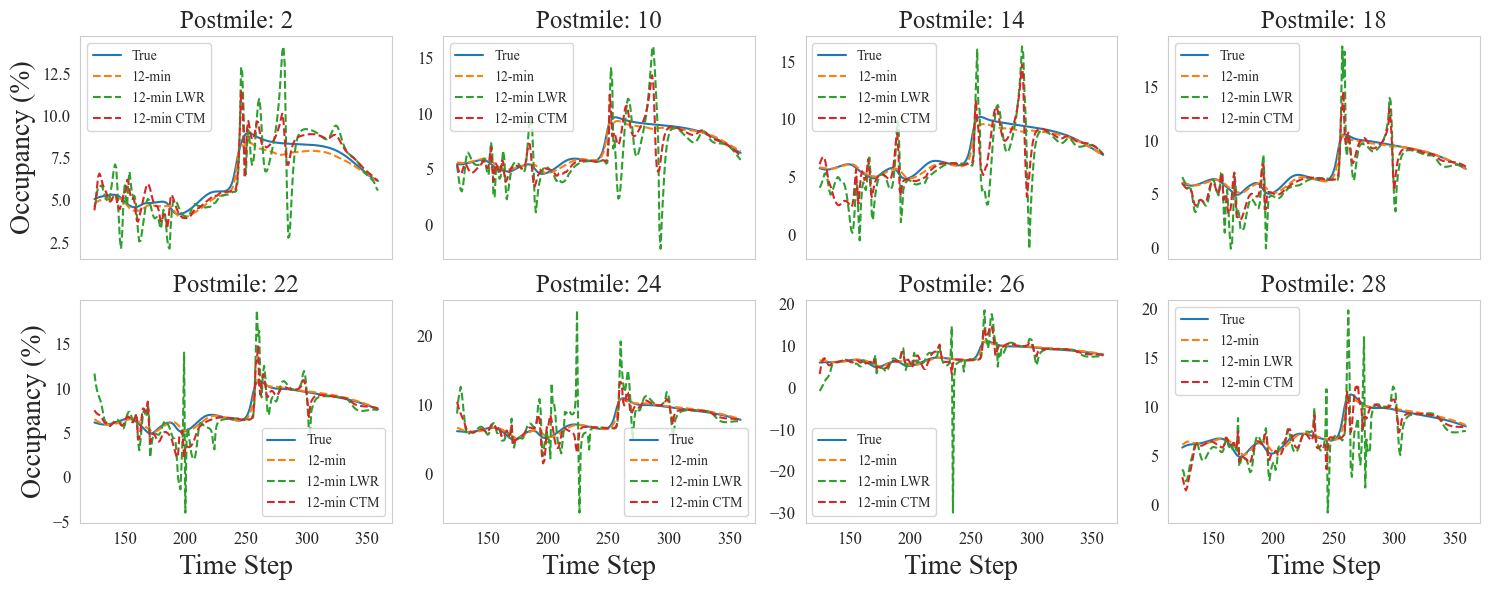

In [50]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6), sharex=True)
axes = axes.flatten()
# select the postmiles (total 8) we need to include in the plot
select_postmile = [1, 5, 7, 9, 11, 12, 13, 14]

for i in range(8):
    col = select_postmile[i]
    axes[i].plot(pred_occu_recon.loc[col,:].iloc[4:], label='True')
    axes[i].plot(pred_occu_4.loc[col,:].iloc[:-4], linestyle = '--', label='12-min')
    axes[i].plot(pred_occu_4_LWR.loc[col,:].iloc[:-4], linestyle = '--', label='12-min LWR')
    axes[i].plot(pred_occu_4_CTM.loc[col,:].iloc[:-4], linestyle = '--', label='12-min CTM')
    axes[i].set_title(f'Postmile: {col * 2}', fontsize = 18)
    # axes[i].set_ylim(-0.6, 0.8)
    
    axes[i].tick_params(axis='both', which='major', labelsize=12)
    axes[i].legend()
    
    if i >= 4:  # Subplots 12 to 15 correspond to the last row (index starts from 0)
        axes[i].set_xlabel('Time Step', fontsize=20)

    # Add y-axis labels only for the subplots in the first column
    if i % 4 == 0:  # Subplots 0, 4, 8, 12 correspond to the first column
        axes[i].set_ylabel('Occupancy (%)', fontsize=20)
    axes[i].grid(False)
    
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'

In [51]:
pred_occu_4_CTM

TimeStep,125,126,127,128,129,130,131,132,133,134,...,354,355,356,357,358,359,360,361,362,363
Station_Number,,,,,,,,,,,,,,,,,,,,,
1,4.413112,5.017639,5.736505,6.391199,6.596002,6.462552,6.178250,5.909233,5.726338,5.587454,...,6.485679,6.423256,6.350668,6.270698,6.220922,6.229845,6.261867,6.283644,6.289092,6.282272
2,5.367950,5.072062,4.839338,4.636173,4.425626,4.430383,4.613003,4.760480,4.812267,4.826657,...,6.403319,6.326090,6.232046,6.103920,5.929268,5.767555,5.722140,5.773909,5.844748,5.909027
3,4.643866,4.938341,5.070858,5.200209,5.415728,5.503540,5.471364,5.461629,5.469846,5.465500,...,6.204470,6.178492,6.160055,6.136625,6.087251,5.982017,5.814719,5.684076,5.673225,5.711572
4,3.246309,3.523245,4.016120,4.577434,5.018003,5.221055,5.249397,5.223985,5.183404,5.140577,...,6.381398,6.288994,6.199297,6.118896,6.054683,6.007284,5.959120,5.863523,5.710939,5.611672
5,5.398018,4.990659,4.701538,4.581251,4.724926,5.097895,5.432003,5.487984,5.315018,5.075953,...,6.703768,6.606726,6.510586,6.415996,6.322298,6.227436,6.130462,6.034276,5.935877,5.805574
6,4.167848,3.911261,3.628603,3.370911,3.269932,3.594340,4.410546,5.660634,6.867132,7.610470,...,7.101535,6.994859,6.884992,6.774240,6.665163,6.560030,6.460251,6.365816,6.275085,6.184386
7,6.114395,6.420751,6.651452,6.751232,6.637877,6.188199,5.543015,4.872905,4.456576,4.198329,...,7.493190,7.401560,7.302134,7.196214,7.085376,6.971917,6.858381,6.747313,6.640930,6.540805
8,4.727152,4.616906,4.556485,4.603268,4.724713,4.932781,5.224422,5.459501,5.457302,5.188246,...,7.734444,7.670565,7.599051,7.519778,7.433335,7.340264,7.241890,7.139698,7.035680,6.931901
9,5.971962,5.836822,5.704588,5.570663,5.504856,5.463329,5.476619,5.447380,5.109409,4.542111,...,7.846659,7.803159,7.753834,7.698591,7.637156,7.569729,7.496350,7.417642,7.334264,7.247329


In [52]:
pred_occu_4_LWR

TimeStep,125,126,127,128,129,130,131,132,133,134,...,354,355,356,357,358,359,360,361,362,363
Station_Number,,,,,,,,,,,,,,,,,,,,,
0,4.185251,5.454051,6.906404,8.390776,8.127270,7.564132,7.006746,6.521006,6.175440,5.904617,...,6.417795,6.357500,6.280210,6.197041,6.186186,6.277935,6.381845,6.451275,6.486987,6.500606
1,4.617212,4.891542,5.376632,5.815584,5.828372,5.861223,5.897316,5.674596,5.422213,5.232791,...,6.246610,6.160204,6.043913,5.881073,5.693273,5.590383,5.652835,5.789420,5.917524,6.017972
2,5.031017,4.906004,4.693728,4.534735,4.491831,4.565187,4.708707,4.851414,4.914924,4.915674,...,5.867564,5.842411,5.798731,5.705756,5.532122,5.296943,5.092312,5.077632,5.212523,5.370504
3,2.812811,3.543179,4.154813,4.733830,5.263535,5.417931,5.339671,5.290942,5.257270,5.201099,...,5.701663,5.631514,5.572299,5.531669,5.503152,5.447083,5.318533,5.120475,4.945865,4.955368
4,2.716782,2.437070,2.242682,3.107676,4.162635,4.951178,5.344858,5.323267,5.073144,4.771360,...,6.037174,5.916686,5.799694,5.691228,5.593155,5.499997,5.396657,5.260685,5.097964,4.925907
5,5.362447,4.463181,3.693540,3.140858,3.009372,3.557673,4.540580,5.632027,6.332288,6.510864,...,6.545461,6.406041,6.264188,6.122965,5.984584,5.849792,5.719349,5.594827,5.468151,5.306634
6,6.160855,6.124970,5.910343,5.468292,4.678198,3.159216,0.979602,-1.165800,-2.419986,-1.628958,...,7.120771,6.985271,6.838321,6.683397,6.524551,6.366328,6.212778,6.066740,5.929233,5.798545
7,4.071001,4.286953,4.557714,4.928121,5.274588,5.346481,5.089197,4.459394,3.794921,3.460753,...,7.541598,7.447373,7.337798,7.213845,7.077400,6.931129,6.778663,6.623943,6.471105,6.323859
8,4.447213,4.279296,4.129092,4.051273,4.177498,4.349820,4.637753,4.830509,4.436032,3.535216,...,7.707140,7.657111,7.594190,7.518004,7.428699,7.326821,7.213557,7.090787,6.960984,6.827142


In [53]:
rmse_occu_4_proposed = np.sqrt(np.nanmean((pred_occu_recon.iloc[:,4:].values - pred_occu_4.iloc[:,:-4].values) ** 2))
print(rmse_occu_4_proposed)

mape_occu_4_proposed = np.nanmean(np.abs((pred_occu_recon.iloc[:,4:].values - pred_occu_4.iloc[:,:-4].values) / pred_occu_recon.iloc[:,4:].values)) * 100
print(mape_occu_4_proposed)

0.2686435
3.0802128836512566


In [54]:
rmse_occu_4_LWR = np.sqrt(np.nanmean((pred_occu_recon.iloc[:,4:].values - pred_occu_4_LWR.iloc[:,:-4].values) ** 2))
print(rmse_occu_4_LWR)

mape_occu_4_LWR = np.nanmean(np.abs((pred_occu_recon.iloc[:,4:].values - pred_occu_4_LWR.iloc[:,:-4].values) / pred_occu_recon.iloc[:,4:].values)) * 100
print(mape_occu_4_LWR)

2.055775422581057
17.101185785755042


In [55]:
rmse_occu_4_CTM = np.sqrt(np.nanmean((pred_occu_recon.iloc[1:,4:].values - pred_occu_4_CTM.iloc[:,:-4].values) ** 2))
print(rmse_occu_4_CTM)

mape_occu_4_CTM = np.nanmean(np.abs((pred_occu_recon.iloc[1:,4:].values - pred_occu_4_CTM.iloc[:,:-4].values) / pred_occu_recon.iloc[1:,4:].values)) * 100
print(mape_occu_4_CTM)

1.0778835
9.62846502661705


### 15 mins prediction

In [56]:
# convert pred_occu_4 to long format and input into Flow Net and Speed Net
pred_occu_4_long = pred_occu_4.transpose().stack().reset_index()
pred_occu_4_long.columns = ['TimeStep', 'Station_Number', 'Occupancy']
# change pred_occu_4_long to torch.tensor type
pred_occu_4_long = torch.tensor(pred_occu_4_long.values)
# input pred_occu_4 into the FlowNet and SpeedNet
flow_4 = Network.FlowNet(pred_occu_4_long.float())
speed_4 = Network.SpeedNet(pred_occu_4_long.float())
# change flow_4 and speed_4 into pandas long format
pred_flow_4_long = torch.cat((pred_occu_4_long.float()[:, :2], flow_1), dim=1)
pred_speed_4_long = torch.cat((pred_occu_4_long.float()[:, :2], speed_1), dim=1)
pred_flow_4_long = pd.DataFrame(pred_flow_4_long.detach().numpy())
pred_speed_4_long = pd.DataFrame(pred_speed_4_long.detach().numpy())
pred_flow_4_long.columns = ['TimeStep', 'Station_Number', 'Flow']
pred_speed_4_long.columns = ['TimeStep', 'Station_Number', 'Speed']
pred_flow_4_long['TimeStep'] = pred_flow_4_long['TimeStep'].astype(int)
pred_flow_4_long['Station_Number'] = pred_flow_4_long['Station_Number'].astype(int)
pred_speed_4_long['TimeStep'] = pred_speed_4_long['TimeStep'].astype(int)
pred_speed_4_long['Station_Number'] = pred_speed_4_long['Station_Number'].astype(int)
# convert these two to wide format
pred_flow_4 = pred_flow_4_long.pivot(index='Station_Number', columns='TimeStep', values='Flow')
pred_speed_4 = pred_speed_4_long.pivot(index='Station_Number', columns='TimeStep', values='Speed')

# use numpy gradiant to calculate the derivatives
# first order
pred_k_x_4 = pd.DataFrame(np.gradient(pred_occu_4.to_numpy(), axis=0), index=pred_occu_4.index,
                          columns=pred_occu_4.columns)
pred_q_x_4 = pd.DataFrame(np.gradient(pred_flow_4.to_numpy(), axis=0), index=pred_flow_4.index,
                          columns=pred_flow_4.columns)
pred_v_x_4 = pd.DataFrame(np.gradient(pred_speed_4.to_numpy(), axis=0), index=pred_speed_4.index,
                          columns=pred_speed_4.columns)

# second order
pred_k_xx_4 = pd.DataFrame(np.gradient(pred_k_x_4.to_numpy(), axis=0), index=pred_k_x_4.index,
                           columns=pred_k_x_4.columns)
pred_q_xx_4 = pd.DataFrame(np.gradient(pred_q_x_4.to_numpy(), axis=0), index=pred_q_x_4.index,
                           columns=pred_q_x_4.columns)
pred_v_xx_4 = pd.DataFrame(np.gradient(pred_v_x_4.to_numpy(), axis=0), index=pred_v_x_4.index,
                           columns=pred_v_x_4.columns)
k_x_4 = pred_k_x_4.transpose().stack().reset_index()
k_x_4 = torch.tensor(k_x_4.values)[:, 2].unsqueeze(1)

q_x_4 = pred_q_x_4.transpose().stack().reset_index()
q_x_4 = torch.tensor(q_x_4.values)[:, 2].unsqueeze(1)

v_x_4 = pred_v_x_4.transpose().stack().reset_index()
v_x_4 = torch.tensor(v_x_4.values)[:, 2].unsqueeze(1)

k_xx_4 = pred_k_xx_4.transpose().stack().reset_index()
k_xx_4 = torch.tensor(k_xx_4.values)[:, 2].unsqueeze(1)

q_xx_4 = pred_q_xx_4.transpose().stack().reset_index()
q_xx_4 = torch.tensor(q_xx_4.values)[:, 2].unsqueeze(1)

v_xx_4 = pred_v_xx_4.transpose().stack().reset_index()
v_xx_4 = torch.tensor(v_xx_4.values)[:, 2].unsqueeze(1)
z_4 = torch.cat((occu_4, flow_4, speed_4, k_x_4, q_x_4, v_x_4, k_xx_4, q_xx_4, v_xx_4), dim=1)
Theta_4 = build_collection_library(z_4, poly_order=params['poly_order'], include_sine=False,
                                   device=torch.device('cpu')).float()
k_t_predict_4 = torch.matmul(Theta_4, coeff)
occu_5 = occu_4 + k_t_predict_4
pred_occu_5 = torch.cat((X_occu_all, occu_5), dim=1).detach().numpy()
pred_occu_5 = pd.DataFrame(pred_occu_5, columns=['TimeStep', 'Station_Number', 'Occupancy'])
pred_occu_5['TimeStep'] = pred_occu_5['TimeStep'].astype(int)
pred_occu_5['Station_Number'] = pred_occu_5['Station_Number'].astype(int)
pred_occu_5 = pred_occu_5.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
# add step size to column index
pred_occu_5.columns = pred_occu_5.columns + 5

In [57]:
# prediction based on LWR Model
# The LWR model: dk/dt = -dq/dx, since we have k = 6*occu, thus d occu/dt = -(1/6)dq/dx
k_t_predict_4_LWR = -(1/6) * q_x_4
occu_5_LWR = occu_4_LWR + k_t_predict_4_LWR

pred_occu_5_LWR = torch.cat((X_occu_all, occu_5_LWR), dim=1).detach().numpy()
pred_occu_5_LWR = pd.DataFrame(pred_occu_5_LWR, columns = ['TimeStep','Station_Number','Occupancy'])
pred_occu_5_LWR['TimeStep'] = pred_occu_5_LWR['TimeStep'].astype(int)
pred_occu_5_LWR['Station_Number'] = pred_occu_5_LWR['Station_Number'].astype(int)
pred_occu_5_LWR = pred_occu_5_LWR.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
pred_occu_5_LWR.columns = pred_occu_5_LWR.columns + 5

In [58]:
pred_occu_5_CTM = pred_occu_4_CTM.values + 1/12 * pred_flow_4.iloc[:-1,:].values - 1/12 * pred_flow_4.iloc[1:,:].values
pred_occu_5_CTM = pd.DataFrame(pred_occu_5_CTM, index=pred_occu_4_CTM.index, columns=pred_occu_4_CTM.columns)
pred_occu_5_CTM.columns = pred_occu_5_CTM.columns + 1

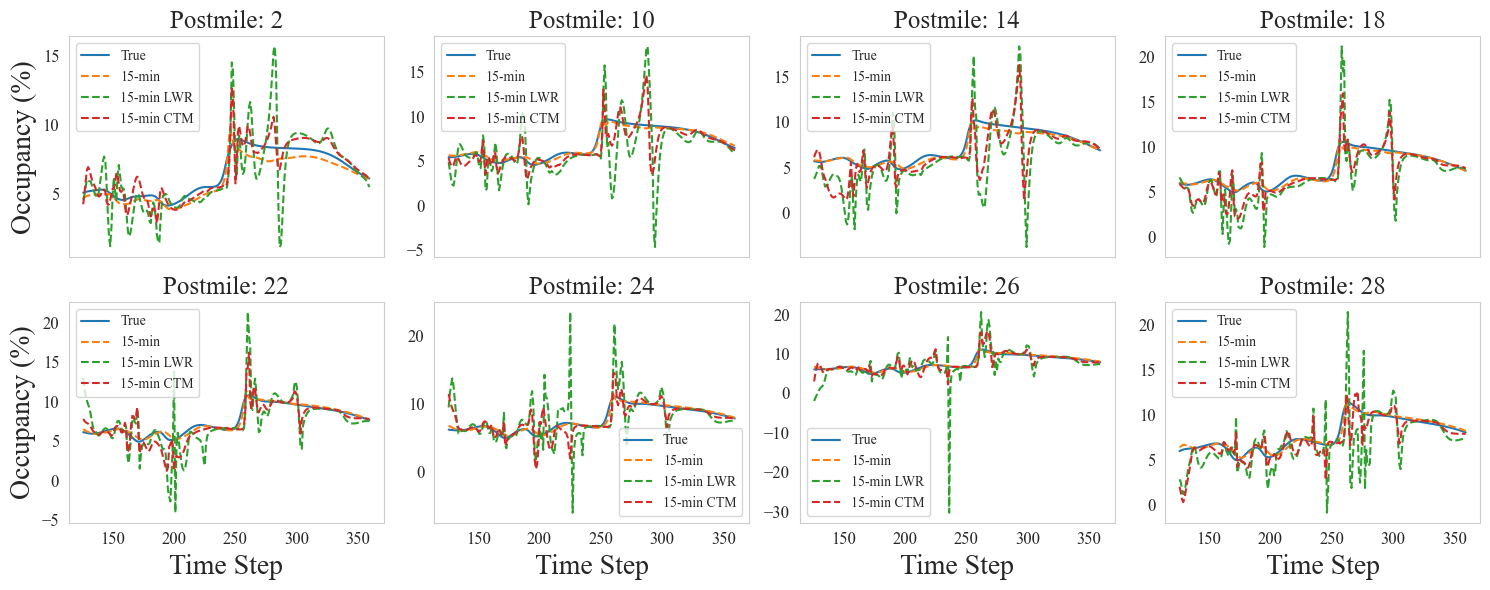

In [59]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6), sharex=True)
axes = axes.flatten()
# select the postmiles (total 8) we need to include in the plot
select_postmile = [1, 5, 7, 9, 11, 12, 13, 14]

for i in range(8):
    col = select_postmile[i]
    axes[i].plot(pred_occu_recon.loc[col,:].iloc[5:], label='True')
    axes[i].plot(pred_occu_5.loc[col,:].iloc[:-5], linestyle = '--', label='15-min')
    axes[i].plot(pred_occu_5_LWR.loc[col,:].iloc[:-5], linestyle = '--', label='15-min LWR')
    axes[i].plot(pred_occu_5_CTM.loc[col,:].iloc[:-5], linestyle = '--', label='15-min CTM')
    axes[i].set_title(f'Postmile: {col * 2}', fontsize = 18)
    # axes[i].set_ylim(-0.6, 0.8)
    
    axes[i].tick_params(axis='both', which='major', labelsize=12)
    axes[i].legend()
    
    if i >= 4:  # Subplots 12 to 15 correspond to the last row (index starts from 0)
        axes[i].set_xlabel('Time Step', fontsize=20)

    # Add y-axis labels only for the subplots in the first column
    if i % 4 == 0:  # Subplots 0, 4, 8, 12 correspond to the first column
        axes[i].set_ylabel('Occupancy (%)', fontsize=20)
    axes[i].grid(False)
    
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'

In [60]:
rmse_occu_5_proposed = np.sqrt(np.nanmean((pred_occu_recon.iloc[:,5:].values - pred_occu_5.iloc[:,:-5].values) ** 2))
print(rmse_occu_5_proposed)

mape_occu_5_proposed = np.nanmean(np.abs((pred_occu_recon.iloc[:,5:].values - pred_occu_5.iloc[:,:-5].values) / pred_occu_recon.iloc[:,5:].values)) * 100
print(mape_occu_5_proposed)

0.3550326
3.898508846759796


In [61]:
rmse_occu_5_LWR = np.sqrt(np.nanmean((pred_occu_recon.iloc[:,5:].values - pred_occu_5_LWR.iloc[:,:-5].values) ** 2))
print(rmse_occu_5_LWR)

mape_occu_5_LWR = np.nanmean(np.abs((pred_occu_recon.iloc[:,5:].values - pred_occu_5_LWR.iloc[:,:-5].values) / pred_occu_recon.iloc[:,5:].values)) * 100
print(mape_occu_5_LWR)

2.474056555389115
21.13672119534709


In [62]:
rmse_occu_5_CTM = np.sqrt(np.nanmean((pred_occu_recon.iloc[1:,5:].values - pred_occu_5_CTM.iloc[:,:-5].values) ** 2))
print(rmse_occu_5_CTM)

mape_occu_5_CTM = np.nanmean(np.abs((pred_occu_recon.iloc[1:,5:].values - pred_occu_5_CTM.iloc[:,:-5].values) / pred_occu_recon.iloc[1:,5:].values)) * 100
print(mape_occu_5_CTM)

1.3729382
12.203740328550339


In [63]:
# combine accuracy data into a dataframe
data = {
    'Prediction Length': ['RMSE(%)', 'MAPE(%)', 'RMSE(%)', 'MAPE(%)', 'RMSE(%)', 'MAPE(%)'],
    '2-min prediction': [rmse_occu_1_LWR, mape_occu_1_LWR, rmse_occu_1_CTM, mape_occu_1_CTM, rmse_occu_1_proposed, mape_occu_1_proposed],
    '4-min prediction': [rmse_occu_2_LWR, mape_occu_2_LWR, rmse_occu_2_CTM, mape_occu_2_CTM, rmse_occu_2_proposed, mape_occu_2_proposed],
    '6-min prediction': [rmse_occu_3_LWR, mape_occu_3_LWR, rmse_occu_3_CTM, mape_occu_3_CTM, rmse_occu_3_proposed, mape_occu_3_proposed],
    '8-min prediction': [rmse_occu_4_LWR, mape_occu_4_LWR, rmse_occu_4_CTM, mape_occu_4_CTM, rmse_occu_4_proposed, mape_occu_4_proposed],
    '10-min prediction': [rmse_occu_5_LWR, mape_occu_5_LWR, rmse_occu_5_CTM, mape_occu_5_CTM, rmse_occu_5_proposed, mape_occu_5_proposed]
}
df = pd.DataFrame(data)
df.iloc[:, 1:] = df.iloc[:, 1:].round(2)
df.to_csv('Tables/Prediction_Error_Proposed.csv', index=False)

### Combine Predictions Plots

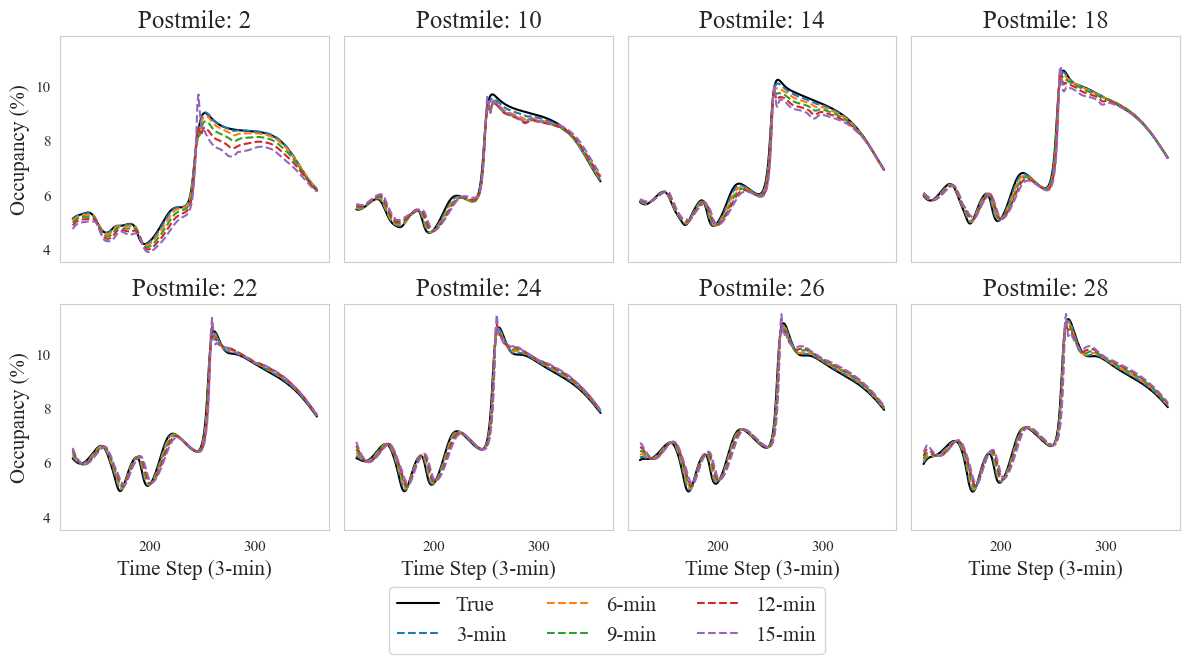

In [64]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6), sharex=True, sharey=True)
axes = axes.flatten()

select_postmile = [1, 5, 7, 9, 11, 12, 13, 14]
# Plotting the data for each row in both dataframes
for i in range(8):
    col = select_postmile[i]
    axes[i].plot(pred_occu_recon.iloc[col, 5:], color = 'black', label='True')
    axes[i].plot(pred_occu_1.iloc[col, 4:-1], linestyle='--', label='3-min')
    axes[i].plot(pred_occu_2.iloc[col, 3:-2], linestyle='--', label='6-min')
    axes[i].plot(pred_occu_3.iloc[col, 2:-3], linestyle='--', label='9-min')
    axes[i].plot(pred_occu_4.iloc[col, 1:-4], linestyle='--', label='12-min')
    axes[i].plot(pred_occu_5.iloc[col, :-5], linestyle='--', label='15-min')
    axes[i].set_title(f'Postmile: {col * 2}', fontsize=18)
    axes[i].tick_params(axis='both', which='major', labelsize=11)
    # axes[i].legend(fontsize = 11)
    axes[i].grid(False)
    
axes[0].set_ylabel('Occupancy (%)', fontsize=15)
axes[4].set_ylabel('Occupancy (%)', fontsize=15)

for i in range(4,8):
    axes[i].set_xlabel('Time Step (3-min)', fontsize=15)
    

handles, labels = axes[0].get_legend_handles_labels()

lgd = fig.legend(handles, labels, bbox_to_anchor=(0.7,0.03), fontsize=15, ncol = 3)

plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'
fig.savefig("Figures/predictions.png", dpi=300, bbox_inches='tight')

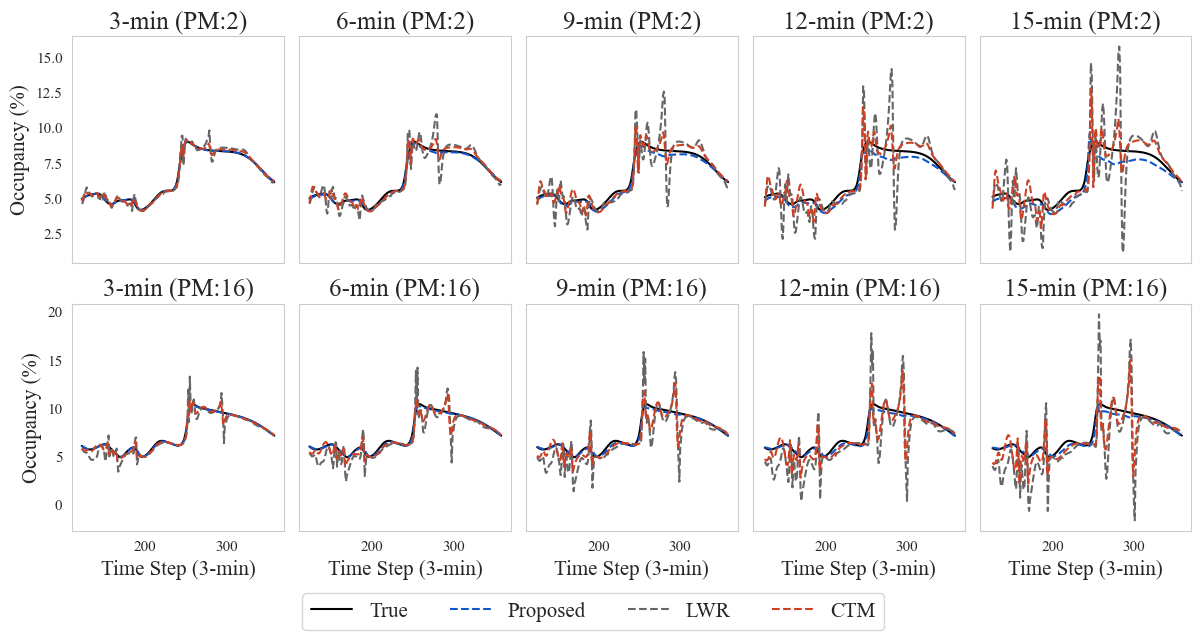

In [71]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6), sharex=True, sharey='row')
axes = axes.flatten()

color_true = '#000000'
color_proposed = '#1155cc'
color_LWR = '#666666'
color_CTM = '#cc4125'

axes[0].plot(pred_occu_recon.loc[1,:].iloc[1:], label='True', color = color_true)
axes[0].plot(pred_occu_1.loc[1,:].iloc[:-1], linestyle = '--', label='Proposed', color=color_proposed)
axes[0].plot(pred_occu_1_LWR.loc[1,:].iloc[:-1], linestyle = '--', label='LWR', color=color_LWR)
axes[0].plot(pred_occu_1_CTM.loc[1,:].iloc[:-1], linestyle = '--', label='CTM', color=color_CTM)
axes[0].set_title('3-min (PM:2)', fontsize = 18)
axes[0].tick_params(axis='both', which='major', labelsize=11)
# axes[0].legend()


axes[1].plot(pred_occu_recon.loc[1,:].iloc[2:], label='True', color = color_true)
axes[1].plot(pred_occu_2.loc[1,:].iloc[:-2], linestyle = '--', label='Proposed', color=color_proposed)
axes[1].plot(pred_occu_2_LWR.loc[1,:].iloc[:-2], linestyle = '--', label='LWR', color=color_LWR)
axes[1].plot(pred_occu_2_CTM.loc[1,:].iloc[:-2], linestyle = '--', label='CTM', color=color_CTM)
axes[1].set_title('6-min (PM:2)', fontsize = 18)
axes[1].tick_params(axis='both', which='major', labelsize=11)
# axes[1].legend()

axes[2].plot(pred_occu_recon.loc[1,:].iloc[3:], label='True', color = color_true)
axes[2].plot(pred_occu_3.loc[1,:].iloc[:-3], linestyle = '--', label='Proposed', color=color_proposed)
axes[2].plot(pred_occu_3_LWR.loc[1,:].iloc[:-3], linestyle = '--', label='LWR', color=color_LWR)
axes[2].plot(pred_occu_3_CTM.loc[1,:].iloc[:-3], linestyle = '--', label='CTM', color=color_CTM)
axes[2].set_title('9-min (PM:2)', fontsize = 18)
axes[2].tick_params(axis='both', which='major', labelsize=11)
# axes[2].legend()

axes[3].plot(pred_occu_recon.loc[1,:].iloc[4:], label='True', color = color_true)
axes[3].plot(pred_occu_4.loc[1,:].iloc[:-4], linestyle = '--', label='Proposed', color=color_proposed)
axes[3].plot(pred_occu_4_LWR.loc[1,:].iloc[:-4], linestyle = '--', label='LWR', color=color_LWR)
axes[3].plot(pred_occu_4_CTM.loc[1,:].iloc[:-4], linestyle = '--', label='CTM', color=color_CTM)
axes[3].set_title('12-min (PM:2)', fontsize = 18)
axes[3].tick_params(axis='both', which='major', labelsize=11)
# axes[3].legend()

axes[4].plot(pred_occu_recon.loc[1,:].iloc[5:], label='True', color = color_true)
axes[4].plot(pred_occu_5.loc[1,:].iloc[:-5], linestyle = '--', label='Proposed', color=color_proposed)
axes[4].plot(pred_occu_5_LWR.loc[1,:].iloc[:-5], linestyle = '--', label='LWR', color=color_LWR)
axes[4].plot(pred_occu_5_CTM.loc[1,:].iloc[:-5], linestyle = '--', label='CTM', color=color_CTM)
axes[4].set_title('15-min (PM:2)', fontsize = 18)
axes[4].tick_params(axis='both', which='major', labelsize=11)
# axes[4].legend()

axes[5].plot(pred_occu_recon.loc[8,:].iloc[1:], label='True', color = color_true)
axes[5].plot(pred_occu_1.loc[8,:].iloc[:-1], linestyle = '--', label='Proposed', color=color_proposed)
axes[5].plot(pred_occu_1_LWR.loc[8,:].iloc[:-1], linestyle = '--', label='LWR', color=color_LWR)
axes[5].plot(pred_occu_1_CTM.loc[8,:].iloc[:-1], linestyle = '--', label='CTM', color=color_CTM)
axes[5].set_title('3-min (PM:16)', fontsize = 18)
axes[5].tick_params(axis='both', which='major', labelsize=11)
# axes[5].legend()

axes[6].plot(pred_occu_recon.loc[8,:].iloc[2:], label='True', color = color_true)
axes[6].plot(pred_occu_2.loc[8,:].iloc[:-2], linestyle = '--', label='Proposed', color=color_proposed)
axes[6].plot(pred_occu_2_LWR.loc[8,:].iloc[:-2], linestyle = '--', label='LWR', color=color_LWR)
axes[6].plot(pred_occu_2_CTM.loc[8,:].iloc[:-2], linestyle = '--', label='CTM', color=color_CTM)
axes[6].set_title('6-min (PM:16)', fontsize = 18)
axes[6].tick_params(axis='both', which='major', labelsize=11)
# axes[6].legend()

axes[7].plot(pred_occu_recon.loc[8,:].iloc[3:], label='True', color = color_true)
axes[7].plot(pred_occu_3.loc[8,:].iloc[:-3], linestyle = '--', label='Proposed', color=color_proposed)
axes[7].plot(pred_occu_3_LWR.loc[8,:].iloc[:-3], linestyle = '--', label='LWR', color=color_LWR)
axes[7].plot(pred_occu_3_CTM.loc[8,:].iloc[:-3], linestyle = '--', label='CTM', color=color_CTM)
axes[7].set_title('9-min (PM:16)', fontsize = 18)
axes[7].tick_params(axis='both', which='major', labelsize=11)
# axes[7].legend()

axes[8].plot(pred_occu_recon.loc[8,:].iloc[4:], label='True', color = color_true)
axes[8].plot(pred_occu_4.loc[8,:].iloc[:-4], linestyle = '--', label='Proposed', color=color_proposed)
axes[8].plot(pred_occu_4_LWR.loc[8,:].iloc[:-4], linestyle = '--', label='LWR', color=color_LWR)
axes[8].plot(pred_occu_4_CTM.loc[8,:].iloc[:-4], linestyle = '--', label='CTM', color=color_CTM)
axes[8].set_title('12-min (PM:16)', fontsize = 18)
axes[8].tick_params(axis='both', which='major', labelsize=11)
# axes[8].legend()

axes[9].plot(pred_occu_recon.loc[8,:].iloc[5:], label='True', color = color_true)
axes[9].plot(pred_occu_5.loc[8,:].iloc[:-5], linestyle = '--', label='Proposed', color=color_proposed)
axes[9].plot(pred_occu_5_LWR.loc[8,:].iloc[:-5], linestyle = '--', label='LWR', color=color_LWR)
axes[9].plot(pred_occu_5_CTM.loc[8,:].iloc[:-5], linestyle = '--', label='CTM', color=color_CTM)
axes[9].set_title('15-min (PM:16)', fontsize = 18)  
axes[9].tick_params(axis='both', which='major', labelsize=11)
# axes[9].legend()

axes[0].set_ylabel('Occupancy (%)', fontsize=15)
axes[5].set_ylabel('Occupancy (%)', fontsize=15)

for i in range(5,10):
    axes[i].set_xlabel('Time Step (3-min)', fontsize=15)

handles, labels = axes[0].get_legend_handles_labels()

for i in range(0,10):
    axes[i].grid(False)

lgd = fig.legend(handles, labels, bbox_to_anchor=(0.74,0.02), fontsize=15, ncol = 4)

plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'
fig.savefig("Figures/predictions_comparsion.png", dpi=300, bbox_inches='tight')